In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ************************************************** PRE PROCESSING **************************************************

# In this section we apply common preprocessing technniques for our Random Fores, XGBoost and GBM
# ---------------------------- LOAD DATASET -----------------------------
def load_dataset(filename):
  return pd.read_csv(filename)

# ------------------------ HANDLE MISSING VALUES ------------------------
def process_empty_values(data):
    for column in data.columns:
        if pd.api.types.is_numeric_dtype(data[column]): # Checking if the cols data type is numeric: either integer or float
            data[column] = data[column].fillna(data[column].mean()) # Assign 'fillna' operation directly to the DataFrame col
        else:  # Assume the col is categorical
            # Handle the situation where the mode calc returns an empty series
            mode_value = data[column].mode()
            if not mode_value.empty:
                data[column] = data[column].fillna(mode_value[0])
            else:
                data[column] = data[column].fillna('Unknown') # If all values are NaN we fill it with a placeholder
    return data

# --------------------------- LABEL ENCODING ---------------------------
# This function assigns unique int to each category, which replaces the original categorical values with numerical values
# Important because the model only works with numerical vals
# Room for improvement (functions couldve not been hardcoded)
def label_encoding(data):
    label_encoder = LabelEncoder()
    data['merchant'] = label_encoder.fit_transform(data['merchant'])
    data['category'] = label_encoder.fit_transform(data['category'])
    return data

# -------------------------- FEATURE SELECTION --------------------------
# This function drops al unnecessary columns
# Room for improvement (functions couldve not been hardcoded)
def drop_unnecessary_cols(data):
  data = data.iloc[:, 1:] 
  cols_to_drop = ['first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time']
  data = data.drop(cols_to_drop, axis=1)
  return data

# ---------------------------- ARE NUMERIC ----------------------------
# This function doucle checks that all the vals in out dataset are numeric
def identify_non_numeric_columns(data):
    non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'int64', 'float64', 'uint8']).columns # ID non numeric cols by checking theyre corresponding data types
    # Print and return the non numeric cols
    if len(non_numeric_cols) > 0:
        print("Non-numeric columns identified:", non_numeric_cols)
    else:
        print("All columns are numeric.")
    return list(non_numeric_cols)

# ------------------ EXPAND trans_date_trans_time FEAT------------------
# This function strictly converts the trans_date_trans_time feature
# Since trans_date_trans_time is a very complicated feaat (it includes several features)
# We decided to split them up to use for feature engineering
def expand_datetime_features(data, datetime_col):
    # Converting the datetime
    data[datetime_col] = pd.to_datetime(data[datetime_col], format="%m/%d/%y %H:%M")
    # Extract components from the datetime column
    data['Year'] = data[datetime_col].dt.year
    data['Month'] = data[datetime_col].dt.month
    data['Day'] = data[datetime_col].dt.day
    data['Hour'] = data[datetime_col].dt.hour
    data['Minute'] = data[datetime_col].dt.minute
    data['Second'] = data[datetime_col].dt.second
    data['Unix_Timestamp'] = data[datetime_col].astype(int) / 10**9
    data.drop(columns=[datetime_col], inplace=True)
    return data

In [3]:
# ------------------------------ LOAD DATA ------------------------------
# The dataset this function is calling only contains 250,000 samples
# If you would like to test using the entire dataset containing 1,000,000+ samples, change to fraudTrain.csv
train_data = load_dataset('../fraudTrain.csv')

# --------------------------- PREPROCESS DATA ---------------------------
train_data = process_empty_values(train_data)
train_data = label_encoding(train_data)
train_data = drop_unnecessary_cols(train_data)
train_data = expand_datetime_features(train_data, 'trans_date_trans_time')

# # ------------------------- LAST MINUTE CHECKS --------------------------
non_numeric_columns = identify_non_numeric_columns(train_data) # Used to double check that all our values are numeric
# Dropping last miinute - not as useful- cols 
columns_to_drop = ['Minute', 'Second']
train_data = train_data.drop(columns=columns_to_drop, axis=1)

# # ----------------------------- SPLIT DATA ------------------------------
# Split data into features and target
X = train_data.drop("is_fraud", axis=1)
y = train_data["is_fraud"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


All columns are numeric.


In [4]:
# ----------------------------- TRAIN MODEL -----------------------------
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')# Creating a Random Forest classifier
xgb_model.fit(X_train, y_train) # Training the classifier on the training data
y_pred = xgb_model.predict(X_test)# Making predictions on the test data
print("Model Trained Successfully")

Model Trained Successfully


---------- Classification Report: ----------
Accuracy: 0.998320016799832
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99412
           1       0.93      0.78      0.85       589

    accuracy                           1.00    100001
   macro avg       0.96      0.89      0.92    100001
weighted avg       1.00      1.00      1.00    100001

---------- Confusion Matrix: ----------


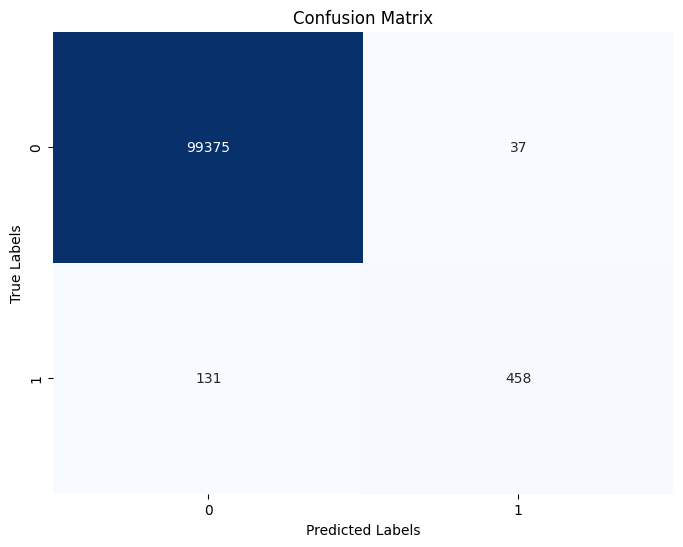

In [5]:
print("---------- Classification Report: ----------")
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("---------- Confusion Matrix: ----------")
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
